# SST correlation and regression maps

## Regressed on a time series filtered to different frequencies

In [13]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np 

In [4]:
# NOAA PSD https://psl.noaa.gov/data/gridded/index.html

URL = 'https://psl.noaa.gov//thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
#thredds/dodsC/Datasets/noaa.oisst.v2/sst.mnmean.nc'
ds = xr.open_dataset(URL)
ds

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 2018, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2022-02-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/38)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    license:                         No constraints on data access or use
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    data_modified:                   2022-03-07
    DODS_EXTRA.Unlimited_Dimension:  time

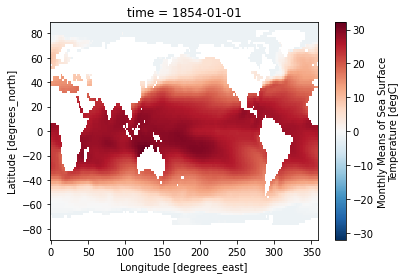

In [5]:
ds.sst[0].plot()

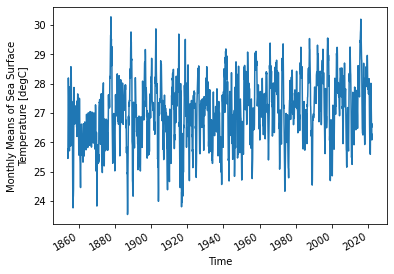

In [192]:
# central equatorial pacific (longitude 200)
CEP = ds.sst.sel(lat=0,lon=200).drop_vars(['lat','lon'])
CEP.plot()

# regress on time to get trend

In [193]:
CEP

<xarray.DataArray 'sst' (time: 2018)>
array([25.767456, 25.456669, 26.654982, ..., 26.085806, 26.286373, 26.18406 ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2022-02-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]
    _ChunkSizes:   [  1  89 180]

In [194]:
# correlation with time is the trend: upward (positive) 0.16435173719492452
timecor = np.corrcoef(CEP.values, range(CEP.size))[1,0]; timecor

0.25779621719935775

582.5463500872698

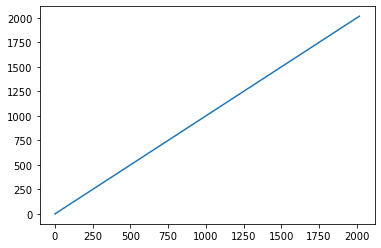

In [195]:
# stdev of a linear trend: units are months 
plt.plot(range(CEP.size))
np.std( range(CEP.size) )

In [196]:
# stdev of SST 
np.std( CEP ).values

array(1.0905969, dtype=float32)

In [197]:
# Slope is K/month units 
slope = timecor *np.std(CEP).values /np.std( range(CEP.size) ); slope

# Trend is a time series of the right shape, equal to the mean plos the trend
trend = CEP.copy()*0 +CEP.mean() + slope*range(CEP.size)

Text(0.5, 1.0, '0N, 180E SST and trend')

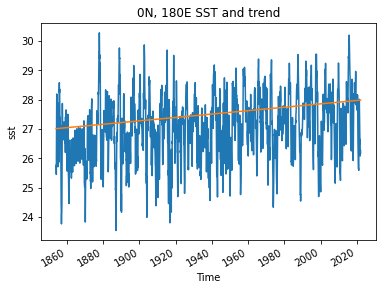

In [198]:
CEP.plot(); trend.plot(); plt.title('0N, 180E SST and trend')

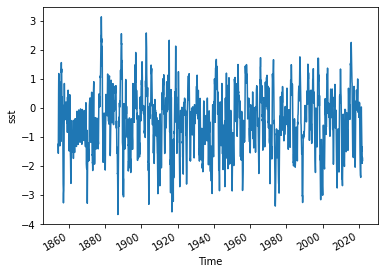

In [199]:
detrend = CEP-trend
detrend.plot()

# Regress on month of year (mm) to get seasonal cycle

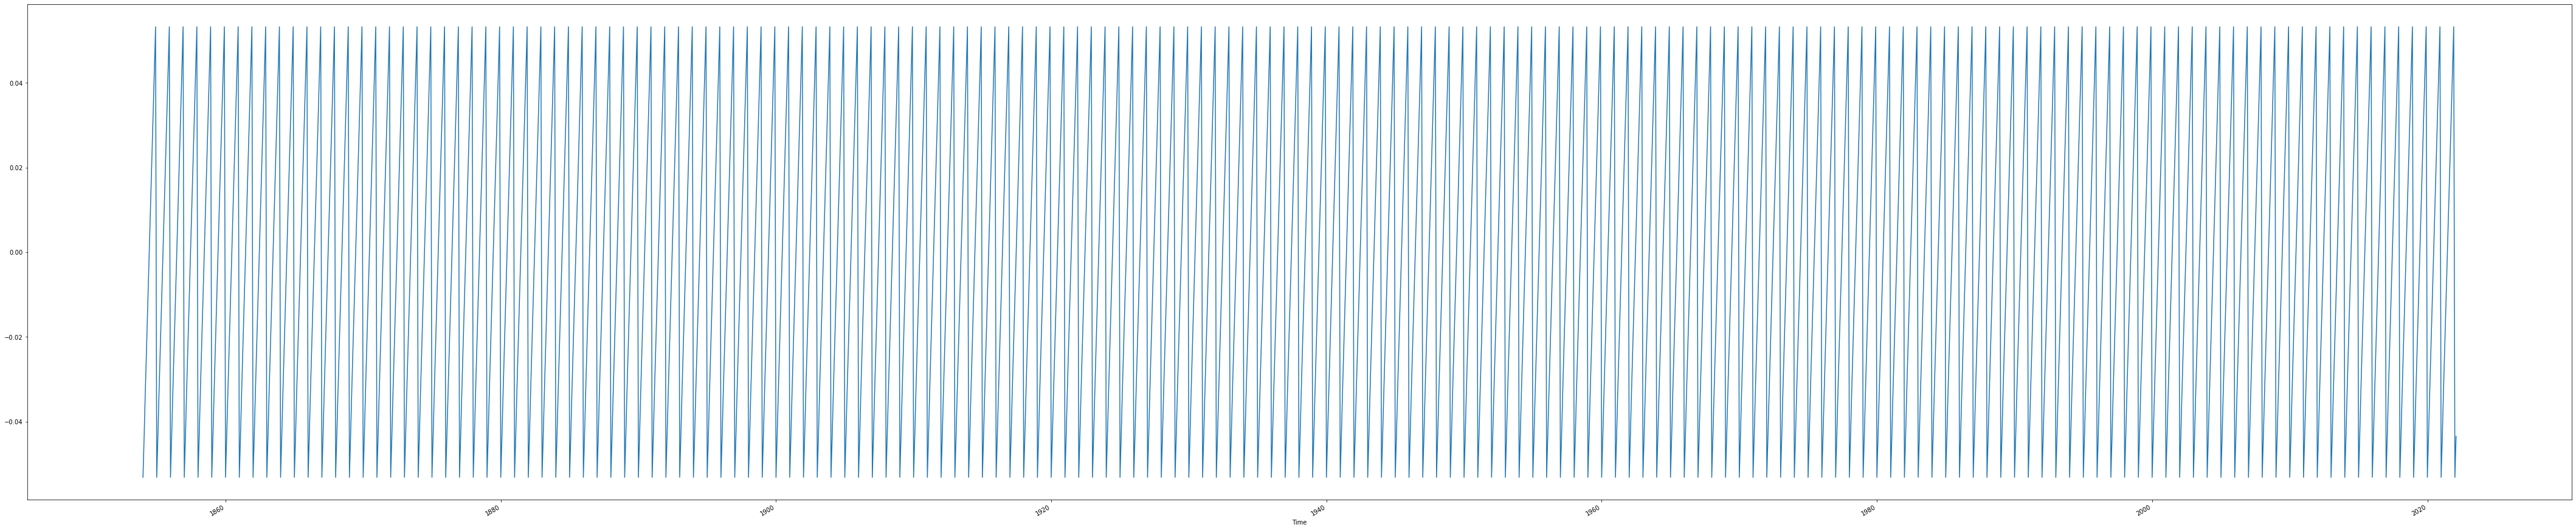

In [200]:
mm = CEP['time.month'] 

mmcor = np.corrcoef(detrend.values, mm)[1,0]      # in [-1,1]
slope = mmcor *np.std(detrend).values /np.std(mm) # K/month units

# seas12 is a time series of the right shape, linear regression slope on mm-mm.mean()
seas12 = detrend.copy()*0 + slope*(mm - mm.mean())
seas12.plot(size=15,aspect=5)

Text(0.5, 1.0, 'Detrended blue, deseasonalized orange')

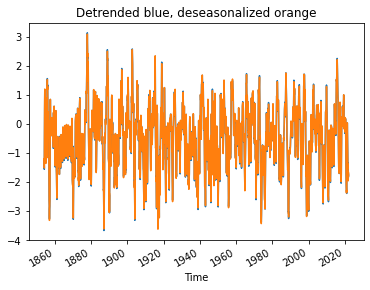

In [201]:
deseas = detrend-seas12
detrend.plot(); deseas.plot(); plt.title('Detrended blue, deseasonalized orange')

# Now low-pass (LP), band-pass(BP), and residual high pass (HP)


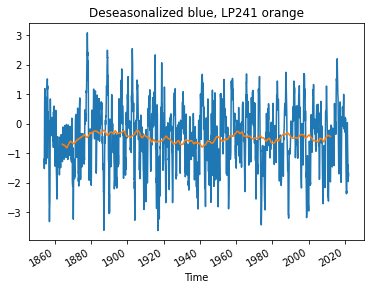

In [214]:
# LP is rolling means over 241 months (20 years)
LP = deseas.rolling(time=241, center=True).mean()# .dropna("time")

deseas.plot(); LP.plot()
plt.title('Deseasonalized blue, LP241 orange')
resid = deseas-LP

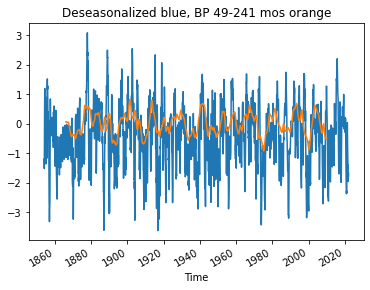

In [215]:
# BP is rolling mean of resid over 49 months (4 years)
BP = resid.rolling(time=49, center=True).mean() #.dropna("time")

deseas.plot(); BP.plot()
plt.title('Deseasonalized blue, BP 49-241 mos orange')
HP = resid-BP

Text(0.5, 1.0, 'HP (49 mos) and VHP (13 mos)')

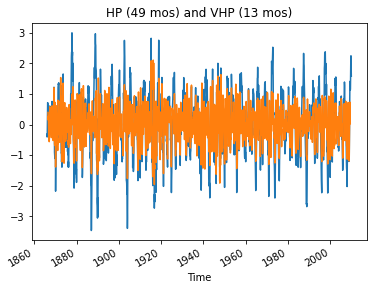

In [216]:
VHP = HP.copy()-HP.rolling(time=13, center=True).mean() #.dropna("time")

HP.plot(); VHP.plot(); plt.title('HP (49 mos) and VHP (13 mos)')

# Make correlation and regression maps from time series: 
## Full CEP @0N-180E, and trend, seas12, LP, BP, HP, VHP.

In [229]:
import warnings
warnings.filterwarnings('ignore')

In [230]:
tsnames = ['trend','seas12','LP','BP','VHP','CEP']

In [231]:
for tsname in tsnames: 
    command = tsname+'corr = xr.corr('+tsname+',ds.sst, dim="time");'# +tsname+'cov.plot(); plt.title('+tsname+')'
    
    print(command)
    exec(command)

trendcorr = xr.corr(trend,ds.sst, dim="time");
seas12corr = xr.corr(seas12,ds.sst, dim="time");
LPcorr = xr.corr(LP,ds.sst, dim="time");
BPcorr = xr.corr(BP,ds.sst, dim="time");
VHPcorr = xr.corr(VHP,ds.sst, dim="time");
CEPcorr = xr.corr(CEP,ds.sst, dim="time");


trend.plot()
trendcorr.plot(); plt.title('trend')
seas12.plot()
seas12corr.plot(); plt.title('seas12')
LP.plot()
LPcorr.plot(); plt.title('LP')
BP.plot()
BPcorr.plot(); plt.title('BP')
VHP.plot()
VHPcorr.plot(); plt.title('VHP')
CEP.plot()
CEPcorr.plot(); plt.title('CEP')


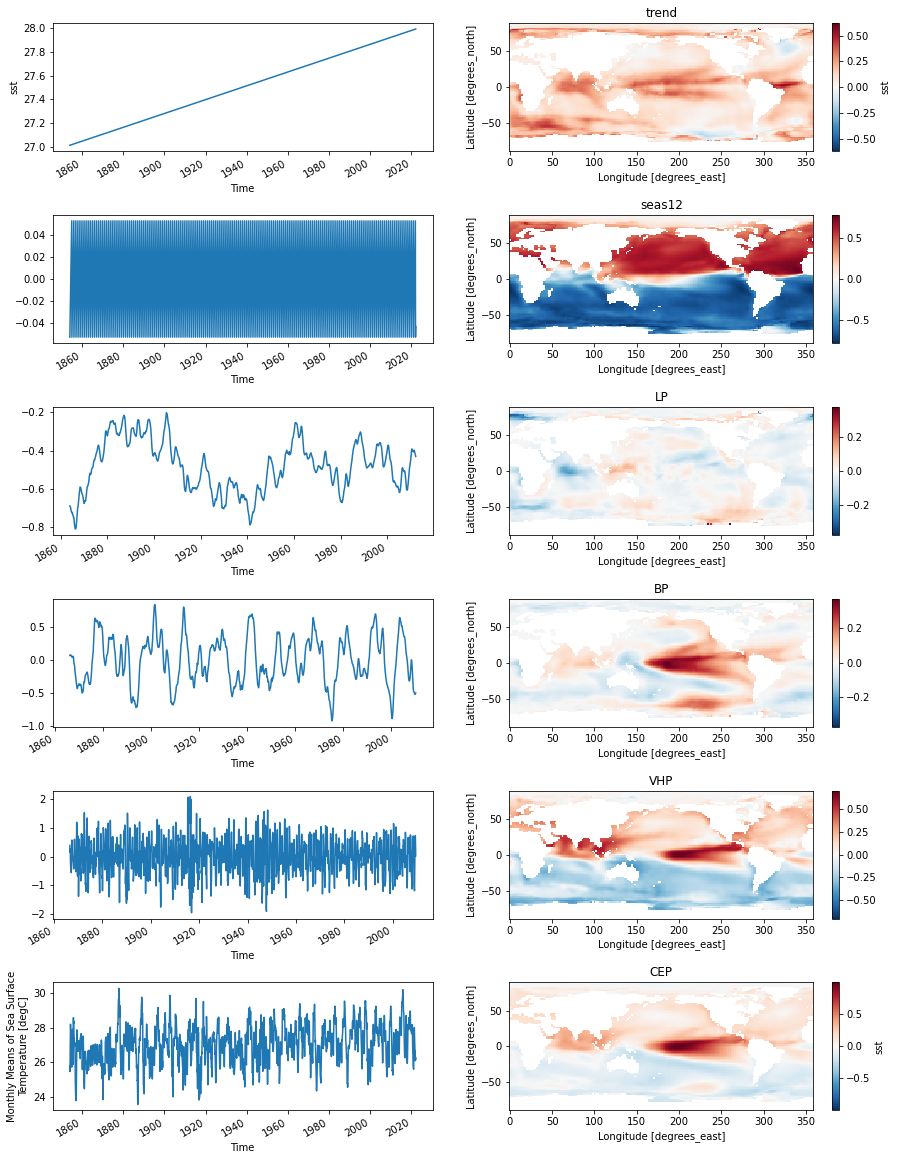

In [232]:
plt.figure(figsize=(15, 20))
plt.subplots_adjust(hspace=0.5)

#fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(14,10))

for i,tsname in enumerate(tsnames):
    ax = plt.subplot(6, 2, 2*i + 1)
    command = tsname+".plot()"
    print(command)
    exec(command)

    ax = plt.subplot(6, 2, 2*i + 2)
    command = tsname+"corr.plot(); plt.title('"+tsname+"')"
    print(command)
    exec(command)